# Induction

This is a simple demonstration of path patching to find induction heads in GPT-2 Small.

(See [*In-context Learning and Induction Heads*](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html) for more on induction heads.)

We'll start by loading the model, wrapping it with the path patching helper code, and tokenising our two inputs. Our two sentences are:

1. I am from the state of New York. New York
2. I am from the state of New Jersey. New York

The first one should strongly trigger induction, i.e. at the second "\_New" we should get a high probability for "\_York". The second one should instead trigger induction for "\_Jersey". By patching in activations from the second sentence into the model running on the first, we can see which attention heads are involved in induction. A patch which strongly increases the probability of "\_Jersey" indicates we have found an induction head.

In [1]:
import gpt2

config, tokenizer, gpt = gpt2.create_gpt2()
model = gpt2.GPT2(config, gpt, verbose=False)

/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inputs = [
    tokenizer("I am from the state of New York. New York", return_tensors="pt"),
    tokenizer("I am from the state of New Jersey. New York", return_tensors="pt")
]

Some helpers. The model outputs the final hidden state, which we need to project into a distribution over the vocabular using the transpose of the embedding matrix, and then take softmax.

In [3]:
import torch

sm = torch.nn.Softmax(dim=2)

def embed_to_distrib(model, embed):
    vocab = torch.matmul(embed, model.model.wte.weight.t())
    return sm(vocab)

def top_vals(tokenizer, res, n=10):
    top_values, top_indices = torch.topk(res, n)
    print(f"{'Index':<20} Value")
    for i in range(len(top_values)):
        tok = tokenizer.decode(top_indices[i].item()).replace(" ", "_").replace("\n", "\\n")
        print(f"{tok:<20} {top_values[i].item()}")

Now we run the path patching and collect probabilities for "\_York" and "\_Jersey" at the position we care about.

In [4]:
p_York, p_Jersey = {}, {}
for layer in range(config.n_layer):
    for head in range(config.n_head):
        
        # when to branch: the attn at the layer of this head
        def branch(path):
            if path[-1] == f"a{layer}": return True
            if path[-1] == f"a{layer}.head": return True
            return False
        
        def which(path):
            if f"a{layer}.head{head}" in path: return 1
            return 0
        
        res = model(inputs, which, branch).hidden_states
        distrib = embed_to_distrib(model, res)[0][9]
        p_York[(layer, head)] = distrib[tokenizer.encode(" York")[0]]
        p_Jersey[(layer, head)] = distrib[tokenizer.encode(" Jersey")[0]]
        print(f"\nLayer {layer}, Head {head}")
        top_vals(tokenizer, distrib, n=2)


Layer 0, Head 0
Index                Value
_York                0.8523692488670349
_Yorkers             0.06456416100263596

Layer 0, Head 1
Index                Value
_York                0.8514811992645264
_Yorkers             0.063127800822258

Layer 0, Head 2
Index                Value
_York                0.8527571558952332
_Yorkers             0.06516562402248383

Layer 0, Head 3
Index                Value
_York                0.847131609916687
_Yorkers             0.06402023881673813

Layer 0, Head 4
Index                Value
_York                0.8560593724250793
_Yorkers             0.06305011361837387

Layer 0, Head 5
Index                Value
_York                0.8400207757949829
_Yorkers             0.06420446187257767

Layer 0, Head 6
Index                Value
_York                0.8483042120933533
_Yorkers             0.06596900522708893

Layer 0, Head 7
Index                Value
_York                0.8527244925498962
_Yorkers             0.06629972904920578

La


Layer 5, Head 9
Index                Value
_York                0.8499428033828735
_Yorkers             0.06521384418010712

Layer 5, Head 10
Index                Value
_York                0.8483749628067017
_Yorkers             0.06717213988304138

Layer 5, Head 11
Index                Value
_York                0.8513269424438477
_Yorkers             0.06396470963954926

Layer 6, Head 0
Index                Value
_York                0.8491204380989075
_Yorkers             0.06669028103351593

Layer 6, Head 1
Index                Value
_York                0.8516501784324646
_Yorkers             0.06451386958360672

Layer 6, Head 2
Index                Value
_York                0.8524507284164429
_Yorkers             0.0647764503955841

Layer 6, Head 3
Index                Value
_York                0.850586473941803
_Yorkers             0.06512421369552612

Layer 6, Head 4
Index                Value
_York                0.8506321310997009
_Yorkers             0.06199730187654495



Layer 11, Head 3
Index                Value
_York                0.844493567943573
_Yorkers             0.06452108919620514

Layer 11, Head 4
Index                Value
_York                0.8506130576133728
_Yorkers             0.065549835562706

Layer 11, Head 5
Index                Value
_York                0.8513917326927185
_Yorkers             0.06497497111558914

Layer 11, Head 6
Index                Value
_York                0.8491591215133667
_Yorkers             0.06531310081481934

Layer 11, Head 7
Index                Value
_York                0.8509334325790405
_Yorkers             0.06544158607721329

Layer 11, Head 8
Index                Value
_York                0.8504979014396667
_Yorkers             0.06528544425964355

Layer 11, Head 9
Index                Value
_York                0.8507881760597229
_Yorkers             0.0650910958647728

Layer 11, Head 10
Index                Value
_York                0.8605650067329407
_Yorkers             0.0648709163069

Finally, the plot! Note  the blue cells in the first graph--these seem to be induction heads! The yellow one appears to be an anti-induction head, since patching it actually *increases* the probability for "\_York" and *decreases* it for "\_Jersey".

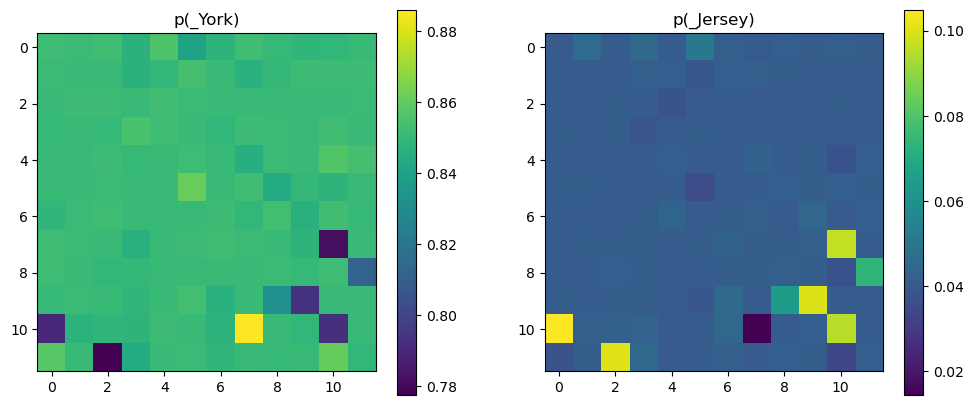

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D numpy array
arr = np.zeros((12, 12))
arr2 = np.zeros((12, 12))

for (row, col), value in p_York.items():
    arr[row, col] = value
    arr2[row, col] = p_Jersey[(row, col)]

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the heatmaps
heatmap1 = ax1.imshow(arr, cmap='viridis')
heatmap2 = ax2.imshow(arr2, cmap='viridis')

# Add colorbars
fig.colorbar(heatmap1, ax=ax1)
fig.colorbar(heatmap2, ax=ax2)

# Set titles
ax1.set_title("p(_York)")
ax2.set_title("p(_Jersey)")

plt.show()

We can try another sentence. How about instead of "\_Jersey" we do something less common, like "\_Japan"?

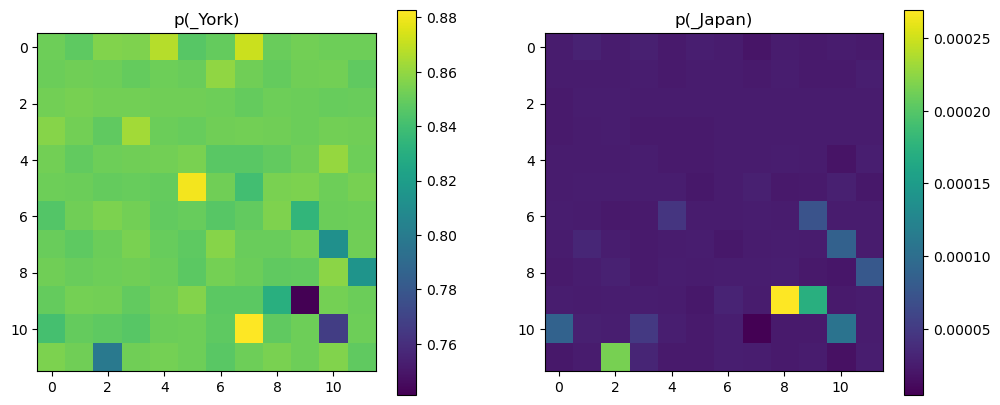

In [7]:
inputs = [
    tokenizer("I am from the state of New York. New York", return_tensors="pt"),
    tokenizer("I am from the state of New Japan. New York", return_tensors="pt")
]

p_York, p_Japan = {}, {}
for layer in range(config.n_layer):
    for head in range(config.n_head):
        
        # when to branch: the attn at the layer of this head
        def branch(path):
            if path[-1] == f"a{layer}": return True
            if path[-1] == f"a{layer}.head": return True
            return False
        
        def which(path):
            if f"a{layer}.head{head}" in path: return 1
            return 0
        
        res = model(inputs, which, branch).hidden_states
        distrib = embed_to_distrib(model, res)[0][9]
        p_York[(layer, head)] = distrib[tokenizer.encode(" York")[0]]
        p_Japan[(layer, head)] = distrib[tokenizer.encode(" Japan")[0]]
        # print(f"\nLayer {layer}, Head {head}")
        # top_vals(tokenizer, distrib, n=2)

# Create a 2D numpy array
arr = np.zeros((12, 12))
arr2 = np.zeros((12, 12))

for (row, col), value in p_York.items():
    arr[row, col] = value
    arr2[row, col] = p_Japan[(row, col)]

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the heatmaps
heatmap1 = ax1.imshow(arr, cmap='viridis')
heatmap2 = ax2.imshow(arr2, cmap='viridis')

# Add colorbars
fig.colorbar(heatmap1, ax=ax1)
fig.colorbar(heatmap2, ax=ax2)

# Set titles
ax1.set_title("p(_York)")
ax2.set_title("p(_Japan)")

plt.show()

Japan overall gets pretty low probability. But some of the induction heads we encountered in the previous graph also are active here, slightly nudging the probability of "\_Japan" up.